In [1]:
import torch
import torch.nn as nn

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class My_Net(nn.Module):
    def __init__(self):
        super(My_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=0, stride=1)
        self.mxpl  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=0, stride=1)
        self.fc1   = nn.Linear(1600,120)
        self.fc2   = nn.Linear(120,84)
        self.fc3   = nn.Linear(84,10)
        
    def forward(self, x):
        out = self.mxpl(F.relu(self.conv1(x)))
        out = F.relu(self.conv2(out))
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        self.fc1   = nn.Linear(3*32*32,128)
        self.fc2   = nn.Linear(128,128)
        self.fc3   = nn.Linear(128,128)
        self.fc4   = nn.Linear(128,10)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [19]:
import functools

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter


class _routing(nn.Module):

    def __init__(self, in_channels, num_experts, dropout_rate):
        super(_routing, self).__init__()
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(in_channels, num_experts)

    def forward(self, x):
        x = torch.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return F.sigmoid(x)
    

class CondConv2D(_ConvNd):
    r"""Learn specialized convolutional kernels for each example.
    As described in the paper
    `CondConv: Conditionally Parameterized Convolutions for Efficient Inference`_ ,
    conditionally parameterized convolutions (CondConv), 
    which challenge the paradigm of static convolutional kernels 
    by computing convolutional kernels as a function of the input.
    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        padding_mode (string, optional): ``'zeros'``, ``'reflect'``, ``'replicate'`` or ``'circular'``. Default: ``'zeros'``
        dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
        num_experts (int): Number of experts per layer 
    Shape:
        - Input: :math:`(N, C_{in}, H_{in}, W_{in})`
        - Output: :math:`(N, C_{out}, H_{out}, W_{out})` where
          .. math::
              H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor
          .. math::
              W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                        \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
    Attributes:
        weight (Tensor): the learnable weights of the module of shape
                         :math:`(\text{out\_channels}, \frac{\text{in\_channels}}{\text{groups}},`
                         :math:`\text{kernel\_size[0]}, \text{kernel\_size[1]})`.
                         The values of these weights are sampled from
                         :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                         :math:`k = \frac{groups}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}`
        bias (Tensor):   the learnable bias of the module of shape (out_channels). If :attr:`bias` is ``True``,
                         then the values of these weights are
                         sampled from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                         :math:`k = \frac{groups}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}`
    .. _CondConv: Conditionally Parameterized Convolutions for Efficient Inference:
       https://arxiv.org/abs/1904.04971
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros', num_experts=3, dropout_rate=0.2):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CondConv2D, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias, padding_mode)

        self._avg_pooling = functools.partial(F.adaptive_avg_pool2d, output_size=(1, 1))
        self._routing_fn = _routing(in_channels, num_experts, dropout_rate)
        
        self.weight = Parameter(torch.Tensor(
            num_experts, out_channels, in_channels // groups, *kernel_size))
        
        self.reset_parameters()

    def _conv_forward(self, input, weight):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._padding_repeated_twice, mode=self.padding_mode),
                            weight, self.bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
    
    def forward(self, inputs):
        b, _, _, _ = inputs.size()
        res = []
        for input in inputs:
            input = input.unsqueeze(0)
            pooled_inputs = self._avg_pooling(input)
            routing_weights = self._routing_fn(pooled_inputs)
            kernels = torch.sum(routing_weights[: ,None, None, None, None] * self.weight, 0)
            out = self._conv_forward(input, kernels)
            res.append(out)
        return torch.cat(res, dim=0)
    
class DIY_Net(nn.Module):
    def __init__(self):
        super(DIY_Net, self).__init__()
        self.conv1 = CondConv2D(3, 6, kernel_size=5, padding=0, stride=1)
        self.mxpl  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = CondConv2D(6, 16, kernel_size=5, padding=0, stride=1)
        self.fc1   = nn.Linear(1600,120)
        self.fc2   = nn.Linear(120,84)
        self.fc3   = nn.Linear(84,10)
        
    def forward(self, x):
        out = self.mxpl(F.relu(self.conv1(x)))
        out = F.relu(self.conv2(out))
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [3]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

PATH = "D:/Jupyter_Data/data"

device = 'cuda'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root=PATH, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
#net = VGG('VGG19')
net = My_Net()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

n_train_images = 0
n_test_images  = 0
per_class_train_images = [0] * 10
per_class_test_images  = [0] * 10
train_mean = torch.zeros(3)
train_var  = torch.zeros(3)
test_mean  = torch.zeros(3)
test_var   = torch.zeros(3)
for batch_idx, (inputs, targets) in enumerate(trainloader):
    n_train_images += len(inputs)
    if (batch_idx == 0):
        print("The size of Image: {}".format(inputs[0].shape))
    for img, lbl in zip(inputs, targets):
        #if (per_class_train_images[lbl] < 5):
            #plt.figure
            #plt.imshow(img.permute(1, 2, 0))
            #plt.savefig("./temp_image/{}_{}.png".format(classes[lbl], per_class_train_images[lbl]))
            #plt.show()
        per_class_train_images[lbl] += 1
    for i in range(3):
        train_mean[i] += inputs[:,i,:,:].mean()
        train_var[i]  += inputs[:,i,:,:].var()
    print(batch_idx, end="\r")
train_mean /= n_train_images
train_var  /= n_train_images
train_std   = torch.sqrt(train_var)
    
for batch_idx, (inputs, targets) in enumerate(testloader):
    n_test_images += len(inputs)
    for img, lbl in zip(inputs, targets):
        per_class_test_images[lbl] += 1
    for i in range(3):
        test_mean[i] += inputs[:,i,:,:].mean()
        test_var[i]  += inputs[:,i,:,:].var()
    print(batch_idx, end="\r")
test_mean /= n_test_images
test_var  /= n_test_images
test_std   = torch.sqrt(test_var)
    
print("The number of Train Images: {}".format(n_train_images))
print("The number of Test Images: {}".format(n_test_images))
print("The number of Classes: {}".format(len(classes)))
print("The number of Images in Train Set by Classes")
for lbl, cnt in zip(classes, per_class_train_images):
    print("Class {}: \t{}".format(lbl, cnt))
print("The number of Images in Test Set by Classes")
for lbl, cnt in zip(classes, per_class_test_images):
    print("Class {}: \t{}".format(lbl, cnt))
print("The mean and standard deviation of the train & test datasets")
print("Train Set")
print("R: (mean:{}, var:{})".format(train_mean[1], train_std[1]))
print("G: (mean:{}, var:{})".format(train_mean[2], train_std[2]))
print("B: (mean:{}, var:{})".format(train_mean[0], train_std[0]))
print("Test Set")
print("R: (mean:{}, var:{})".format(test_mean[1], test_std[1]))
print("G: (mean:{}, var:{})".format(test_mean[2], test_std[2]))
print("B: (mean:{}, var:{})".format(test_mean[0], test_std[0]))

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
The size of Image: torch.Size([3, 32, 32])
The number of Train Images: 50000
The number of Test Images: 10000
The number of Classes: 10
The number of Images in Train Set by Classes
Class plane: 	5000
Class car: 	5000
Class bird: 	5000
Class cat: 	5000
Class deer: 	5000
Class dog: 	5000
Class frog: 	5000
Class horse: 	5000
Class ship: 	5000
Class truck: 	5000
The number of Images in Test Set by Classes
Class plane: 	1000
Class car: 	1000
Class bird: 	1000
Class cat: 	1000
Class deer: 	1000
Class dog: 	1000
Class frog: 	1000
Class horse: 	1000
Class ship: 	1000
Class truck: 	1000
The mean and standard deviation of the train & test datasets
Train Set
R: (mean:0.1205398365855217, var:0.11759582161903381)
G: (mean:0.11163279414176941, var:0.12496599555015564)
B: (mean:0.12284999340772629, var:0.11925093829631805)
Test Set
R: (mean:0.12128286063671112, var:0.11741118133068085

In [4]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs),
                len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.item()), end="\r")
    return train_loss

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                    test_loss, correct, len(testloader.dataset),
                    100. * correct / (len(testloader.dataset))), end="\r")
    return test_loss, 100. * correct / (len(testloader.dataset))

train_losses = list()
test_losses  = list()
test_accuracy= list()
total_start_time = time.time()
for epoch in range(start_epoch, start_epoch+5):
    start_time = time.time()
    train_losses.append(train(epoch))
    loss, acc = test(epoch)
    test_losses.append(loss)
    test_accuracy.append(acc)
    end_time = time.time()
    print("Epoch Time = {}".format(end_time - start_time))
total_end_time = time.time()
print("Total Time = {}".format(total_end_time - total_start_time))


Epoch: 0
Epoch Time = 61.98599743843078626, Accuracy: 4359/10000 (44%)

Epoch: 1
Epoch Time = 59.49799990653992387, Accuracy: 5188/10000 (52%)

Epoch: 2
Epoch Time = 60.63295841217041166, Accuracy: 5324/10000 (53%)

Epoch: 3
Epoch Time = 60.93770503997803014, Accuracy: 5522/10000 (55%)

Epoch: 4
Epoch Time = 61.31099939346313556, Accuracy: 5595/10000 (56%)
Total Time = 304.3656601905823


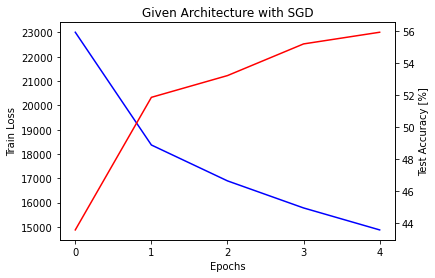

In [5]:
epoches = [0, 1, 2, 3, 4]
f, ax = plt.subplots()
ax.plot(train_losses,'b-')
ax.set_xlabel("Epochs")
ax.set_ylabel("Train Loss")
plt.xticks(epoches)
plt.title("Given Architecture with SGD")

ax2 = ax.twinx()
ax2.plot(test_accuracy,'r-')
ax2.set_ylabel("Test Accuracy [%]")
plt.savefig("./temp_image/loss_accuracy_plot_given_sgd.png")
plt.show()


Epoch: 0
Epoch Time = 51.61199951171875777, Accuracy: 3639/10000 (36%)

Epoch: 1
Epoch Time = 51.35899734497078297, Accuracy: 4333/10000 (43%)

Epoch: 2
Epoch Time = 51.32681274414062552, Accuracy: 4215/10000 (42%)

Epoch: 3
Epoch Time = 51.89304709434509007, Accuracy: 4393/10000 (44%)

Epoch: 4
Epoch Time = 51.66854906082153417, Accuracy: 4619/10000 (46%)
Total Time = 257.86040806770325


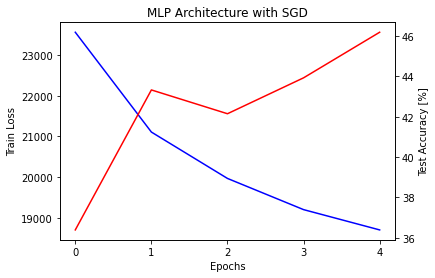

In [6]:
#net = My_Net()
net = MLP_Net()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

train_losses = list()
test_losses  = list()
test_accuracy= list()
total_start_time = time.time()
for epoch in range(start_epoch, start_epoch+5):
    start_time = time.time()
    train_losses.append(train(epoch))
    loss, acc = test(epoch)
    test_losses.append(loss)
    test_accuracy.append(acc)
    end_time = time.time()
    print("Epoch Time = {}".format(end_time - start_time))
total_end_time = time.time()
print("Total Time = {}".format(total_end_time - total_start_time))

f, ax = plt.subplots()
ax.plot(train_losses,'b-')
ax.set_xlabel("Epochs")
ax.set_ylabel("Train Loss")
plt.xticks(epoches)
plt.title("MLP Architecture with SGD")

ax2 = ax.twinx()
ax2.plot(test_accuracy,'r-')
ax2.set_ylabel("Test Accuracy [%]")
plt.savefig("./temp_image/loss_accuracy_plot_mlp_sgd.png")
plt.show()

tensor([0.1228, 0.1205, 0.1116])
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
Epoch Time = 59.78694915771484442, Accuracy: 4316/10000 (43%)

Epoch: 1
Epoch Time = 59.74753332138061532, Accuracy: 4938/10000 (49%)

Epoch: 2
Epoch Time = 60.12004518508911345, Accuracy: 5173/10000 (52%)

Epoch: 3
Epoch Time = 60.02937030792236250, Accuracy: 5295/10000 (53%)

Epoch: 4
Epoch Time = 59.76662707328796408, Accuracy: 5138/10000 (51%)
Total Time = 299.4515266418457


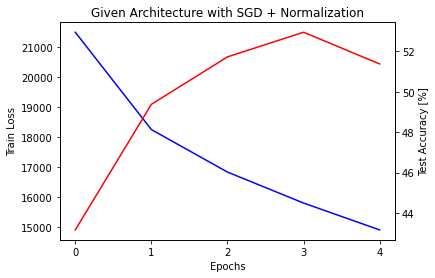

In [7]:
print(train_mean)
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root=PATH, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

net = My_Net()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

train_losses = list()
test_losses  = list()
test_accuracy= list()
total_start_time = time.time()
for epoch in range(start_epoch, start_epoch+5):
    start_time = time.time()
    train_losses.append(train(epoch))
    loss, acc = test(epoch)
    test_losses.append(loss)
    test_accuracy.append(acc)
    end_time = time.time()
    print("Epoch Time = {}".format(end_time - start_time))
total_end_time = time.time()
print("Total Time = {}".format(total_end_time - total_start_time))

f, ax = plt.subplots()
ax.plot(train_losses,'b-')
ax.set_xlabel("Epochs")
ax.set_ylabel("Train Loss")
plt.xticks(epoches)
plt.title("Given Architecture with SGD + Normalization")

ax2 = ax.twinx()
ax2.plot(test_accuracy,'r-')
ax2.set_ylabel("Test Accuracy [%]")
plt.savefig("./temp_image/loss_accuracy_plot_given_sgd_norm.png")
plt.show()


Epoch: 0
Epoch Time = 68.61397886276245736, Accuracy: 4790/10000 (48%)

Epoch: 1
Epoch Time = 66.19771528244019645, Accuracy: 4924/10000 (49%)

Epoch: 2
Epoch Time = 66.496999502182.8507, Accuracy: 5133/10000 (51%)

Epoch: 3
Epoch Time = 66.01800036430359540, Accuracy: 5198/10000 (52%)

Epoch: 4
Epoch Time = 66.27099990844727053, Accuracy: 5142/10000 (51%)
Total Time = 333.5976939201355


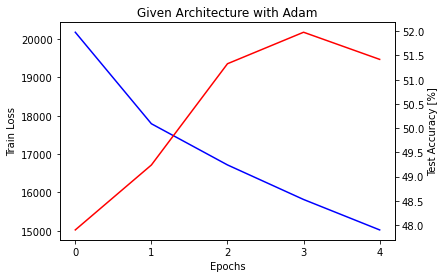

In [9]:
net = My_Net()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

train_losses = list()
test_losses  = list()
test_accuracy= list()
total_start_time = time.time()
for epoch in range(start_epoch, start_epoch+5):
    start_time = time.time()
    train_losses.append(train(epoch))
    loss, acc = test(epoch)
    test_losses.append(loss)
    test_accuracy.append(acc)
    end_time = time.time()
    print("Epoch Time = {}".format(end_time - start_time))
total_end_time = time.time()
print("Total Time = {}".format(total_end_time - total_start_time))

f, ax = plt.subplots()
ax.plot(train_losses,'b-')
ax.set_xlabel("Epochs")
ax.set_ylabel("Train Loss")
plt.xticks(epoches)
plt.title("Given Architecture with Adam")

ax2 = ax.twinx()
ax2.plot(test_accuracy,'r-')
ax2.set_ylabel("Test Accuracy [%]")
plt.savefig("./temp_image/loss_accuracy_plot_given_adam.png")
plt.show()


Epoch: 0
Epoch Time = 142.1750023365020807, Accuracy: 4335/10000 (43%)

Epoch: 1
Epoch Time = 141.3789987564087468, Accuracy: 4958/10000 (50%)

Epoch: 2
Epoch Time = 141.3510007858276407, Accuracy: 5425/10000 (54%)

Epoch: 3
Epoch Time = 141.1909976005554255, Accuracy: 5666/10000 (57%)

Epoch: 4
Epoch Time = 140.9990007877349922, Accuracy: 5728/10000 (57%)
Total Time = 707.096001625061


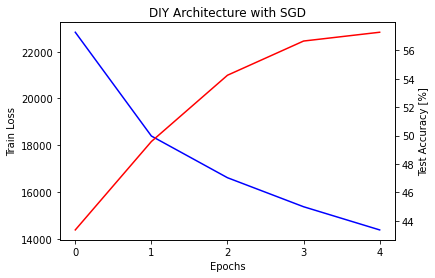

In [21]:
net = DIY_Net()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

train_losses = list()
test_losses  = list()
test_accuracy= list()
total_start_time = time.time()
for epoch in range(start_epoch, start_epoch+5):
    start_time = time.time()
    train_losses.append(train(epoch))
    loss, acc = test(epoch)
    test_losses.append(loss)
    test_accuracy.append(acc)
    end_time = time.time()
    print("Epoch Time = {}".format(end_time - start_time))
total_end_time = time.time()
print("Total Time = {}".format(total_end_time - total_start_time))

f, ax = plt.subplots()
ax.plot(train_losses,'b-')
ax.set_xlabel("Epochs")
ax.set_ylabel("Train Loss")
plt.xticks(epoches)
plt.title("DIY Architecture with SGD")

ax2 = ax.twinx()
ax2.plot(test_accuracy,'r-')
ax2.set_ylabel("Test Accuracy [%]")
plt.savefig("./temp_image/loss_accuracy_plot_diy_sgd.png")
plt.show()